In [69]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

variable_qubits = []
disagree_list = []
check_qubits = []
output_qubit = 9
qc = QuantumCircuit(5)
qubits_a = [0, 1]
qubits_b = [2, 3]
check_qubit = 4

In [70]:
def graph_color_prep(variable_qubits):

  num_vars = len(variable_qubits)
  prep = QuantumCircuit(num_vars)

  for i in range(num_vars):
    prep.h(i)

  return prep

Initialize the oracle circuit
The number of qubits for the oracle circuit will be the sum of variable qubits, check qubits, and output qubits. After initializing the circuit the output qubit will be put into |-> state.

In [71]:
num_vars = len(variable_qubits)
num_checks = len(check_qubits)
num_outputs = 1
oracle = QuantumCircuit(num_vars+num_checks+num_outputs)
oracle.x(output_qubit)
oracle.h(output_qubit)

CircuitError: 'Index 9 out of range for size 1.'

 For comparing the colors of the two countries, we will get 16 states of which the following 4 are unacceptable as they represent the same color-

11 11 (black black)

01 01 (red red)

10 10 (orange orange)

00 00 (black black)

We will use the following logic to flip the output_qubit-

Check if the qubits are in the 11 11 state.
Check if the qubits are in the 01 01 state.
Check if the qubits are in the 10 10 state.
Check if the qubits are in the 00 00 state.
If none of these states have been found, flip the output qubit.

In [72]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate

def disagree_check(qc, qubits_a, qubits_b, check_qubit):
    # 1. Check if the qubits are in the 11 11 state.
    qc.append(MCXGate(len(qubits_a + qubits_b)), qubits_a + qubits_b + [check_qubit])

    # 2. Check if the qubits are in the 01 01 state.
    qc.x(qubits_a[1])
    qc.x(qubits_b[1])
    qc.append(MCXGate(len(qubits_a + qubits_b)), qubits_a + qubits_b + [check_qubit])
    qc.x(qubits_a[1])
    qc.x(qubits_b[1])

    # 3. Check if the qubits are in the 10 10 state.
    qc.x(qubits_a[0])
    qc.x(qubits_b[0])
    qc.append(MCXGate(len(qubits_a + qubits_b)), qubits_a + qubits_b + [check_qubit])
    qc.x(qubits_a[0])
    qc.x(qubits_b[0])
    
    # 4. Check if the qubits are in the 00 00 state.
    qc.x(qubits_a)
    qc.x(qubits_b)
    qc.append(MCXGate(len(qubits_a + qubits_b)), qubits_a + qubits_b + [check_qubit])
    qc.x(qubits_a)
    qc.x(qubits_b)


reset the check qubits

In [73]:
def undo_disagree_check(qc, qubits_a, qubits_b, check_qubit, ancillas):
  # 4. Check if the qubits are in the 00 00 state.
  qc.x(qubits_a)
  qc.x(qubits_b)
  qc.mcx(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a)
  qc.x(qubits_b)


  # 3. Check if the qubits are in the 10 10 state.
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
  qc.mcx(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])

  # 2. Check if the qubits are in the 01 01 state.
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])
  qc.mcx(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])

  # 1. Check if the qubits are in the 11 11 state.
  qc.mcx(qubits_a + qubits_b, check_qubit)

In [74]:
def graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit):

  # 1. Initializing a quantum circuit with the output bit in the |−⟩ state.
  num_vars = len(variable_qubits)
  num_checks = len(check_qubits)
  num_outputs = 1

  oracle = QuantumCircuit(num_vars + num_checks + num_outputs)
  oracle.x(output_qubit)
  oracle.h(output_qubit)


  # 2. Checking if each pair of qubits in a given list, disagree_list, disagree with each other.
  # Storing the ancilla qubits used for each check
  ancillas = []
  for i in range(len(disagree_list)):
    ancillas += [ disagree_check(oracle,
                                  disagree_list[i][0],
                                  disagree_list[i][1],
                                  check_qubits[i]) ]


  # 3. Flip the output bit if all disagreements are satisfied.
  oracle.mcx(check_qubits, output_qubit)


  # 4. Resetting all the extra qubits for the next iteration.
  # Need to include the specific ancillas used for each check
  for i in range(len(disagree_list)):
    undo_disagree_check(oracle,
                           disagree_list[i][0],
                           disagree_list[i][1],
                           check_qubits[i],
                           ancillas[i])


  return oracle

function that takes a string representation of a state and checks if the bits disagree with each other

In [75]:
def check_disagree_list_general(state, disagree_list):

  for i in range(len(disagree_list)):

    if (state[disagree_list[i][0][0]] == state[disagree_list[i][1][0]]
        and state[disagree_list[i][0][1]] == state[disagree_list[i][1][1]]):
        return False 

  return True

In [76]:
# import networkx as nx
# import matplotlib.pyplot as plt
# def get_quantum_coloring_input():
#     # Ask for the number of countries/nodes
#     num_countries = int(input("Enter the number of countries/nodes in the graph: "))
# 
#     # Initialize lists
#     variable_qubits = []
#     disagree_list = []
#     adjacency_list = {}
# 
#     # Each country will need two qubits to represent the color
#     for i in range(num_countries):
#         country_qubits = [i*2, i*2+1]
#         variable_qubits.extend(country_qubits)
#         adjacency_list[i] = []
# 
#         # Ask for adjacent countries/nodes for each country/node
#         adjacent_countries = input(f"Enter the adjacent countries/nodes for country/node {i}, separated by spaces: ")
#         adjacency_list[i] = [int(x) for x in adjacent_countries.split()]
# 
#     # Generate the disagree_list based on the adjacency_list
#     for i in range(num_countries):
#         for j in adjacency_list[i]:
#             if i < j:  # To avoid duplicates like [1,2] and [2,1]
#                 disagree_list.append([[i*2, i*2+1], [j*2, j*2+1]])
# 
#     # Check qubits start after the last variable qubit
#     check_qubits = list(range(len(variable_qubits), len(variable_qubits) + len(disagree_list)))
# 
#     # The output qubit is the next qubit after the last check qubit
#     output_qubit = check_qubits[-1] + 1
# 
#     return {
#         'variable_qubits': variable_qubits,
#         'disagree_list': disagree_list,
#         'check_qubits': check_qubits,
#         'output_qubit': output_qubit,
#         'adjacency_list': adjacency_list  # To check the result
#     }



# Since we cannot interactively ask for user input in this environment,
# let's define a function that takes the number of nodes and adjacency list as input.

# def plot_graph(adjacency_list):
#     # Create a graph object
#     G = nx.Graph()
# 
#     # Add nodes and edges to the graph
#     for node, neighbours in adjacency_list.items():
#         for neighbour in neighbours:
#             G.add_edge(node, neighbour)
# 
#     # Draw the graph
#     nx.draw(G, with_labels=True)
#     plt.show()

# inputGraph = get_quantum_coloring_input()
# plot_graph(inputGraph.get('adjacency_list'))


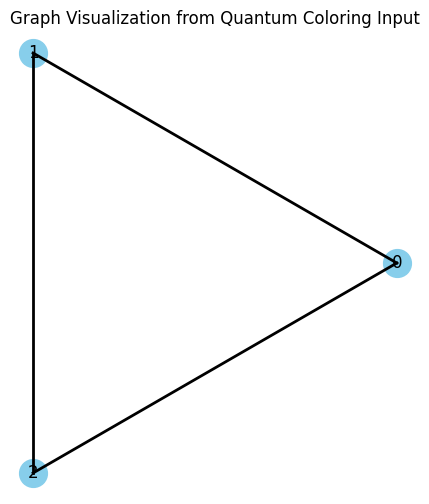

In [83]:
# import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
def get_quantum_coloring_input():
    # Ask for the number of countries/nodes
    num_countries = int(input("Enter the number of countries/nodes in the graph: "))

    # Initialize lists
    variable_qubits = []
    disagree_list = []
    adjacency_list = {}

    # Each country will need two qubits to represent the color
    for i in range(num_countries):
        country_qubits = [i*2, i*2+1]
        variable_qubits.extend(country_qubits)
        adjacency_list[i] = []

        # Ask for adjacent countries/nodes for each country/node
        adjacent_countries = input(f"Enter the adjacent countries/nodes for country/node {i}, separated by spaces: ")
        adjacency_list[i] = [int(x) for x in adjacent_countries.split()]

    # Generate the disagree_list based on the adjacency_list
    for i in range(num_countries):
        for j in adjacency_list[i]:
            if i < j:  # To avoid duplicates like [1,2] and [2,1]
                disagree_list.append([[i*2, i*2+1], [j*2, j*2+1]])

    # Check qubits start after the last variable qubit
    check_qubits = list(range(len(variable_qubits), len(variable_qubits) + len(disagree_list)))

    # The output qubit is the next qubit after the last check qubit
    output_qubit = check_qubits[-1] + 1

    return {
        'variable_qubits': variable_qubits,
        'disagree_list': disagree_list,
        'check_qubits': check_qubits,
        'output_qubit': output_qubit,
        'adjacency_list': adjacency_list  # To check the result
    }

def plot_graph_from_input(input_data):
    """
    Plots the graph based on the adjacency list from the quantum coloring input data.
    """
    # Extract the adjacency list from the input data
    adjacency_list = input_data['adjacency_list']
    
    # Create figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate positions for the nodes so they are placed in a circle
    num_nodes = len(adjacency_list)
    positions = {node: (np.cos(2 * np.pi * node / num_nodes), np.sin(2 * np.pi * node / num_nodes))
                 for node in adjacency_list}
    
    # Draw nodes
    for node, pos in positions.items():
        ax.plot(pos[0], pos[1], 'o', color='skyblue', markersize=20)
        
    # Draw edges and labels
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            if node < neighbor:  # To ensure each edge is drawn once
                start_pos, end_pos = positions[node], positions[neighbor]
                ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-', lw=2)
                
        # Add labels centered at the node positions
        ax.text(positions[node][0], positions[node][1], str(node), color='black', fontsize=12, ha='center', va='center')
    
    # Set aspect and remove axes for clarity
    ax.set_aspect('equal')
    plt.axis('off')
    plt.title('Graph Visualization from Quantum Coloring Input')
    plt.show()



result = get_quantum_coloring_input()

# print(result)
# plot_graph(result.get('adjacency_list'))
plot_graph_from_input(result)

In [84]:
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.opflow import CircuitSampler
from qiskit import Aer
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

# variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7]
variable_qubits = result.get('variable_qubits')
# check_qubits = [8, 9, 10, 11, 12, 13]
check_qubits = result.get('check_qubits')
# 
# disagree_list = [ [[0, 1], [2, 3]],
#                   [[0, 1], [4, 5]],
#                   [[0, 1], [6, 7]],
#                   [[2, 3], [4, 5]],
#                   [[2, 3], [6, 7]],
#                   [[4, 5], [6, 7]]
#                  ]
disagree_list = result.get('disagree_list')

output_qubit = result.get('output_qubit')
# output_qubit = 14

# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)


/var/folders/2_/qlpzqzms15122l6kvxdp657w0000gn/T/ipykernel_18705/3359717414.py:38: DeprecationWarning: ``qiskit.algorithms.amplitude_amplifiers.grover.Grover.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))


/var/folders/2_/qlpzqzms15122l6kvxdp657w0000gn/T/ipykernel_18705/2643686439.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
/var/folders/2_/qlpzqzms15122l6kvxdp657w0000gn/T/ipykernel_18705/2643686439.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')


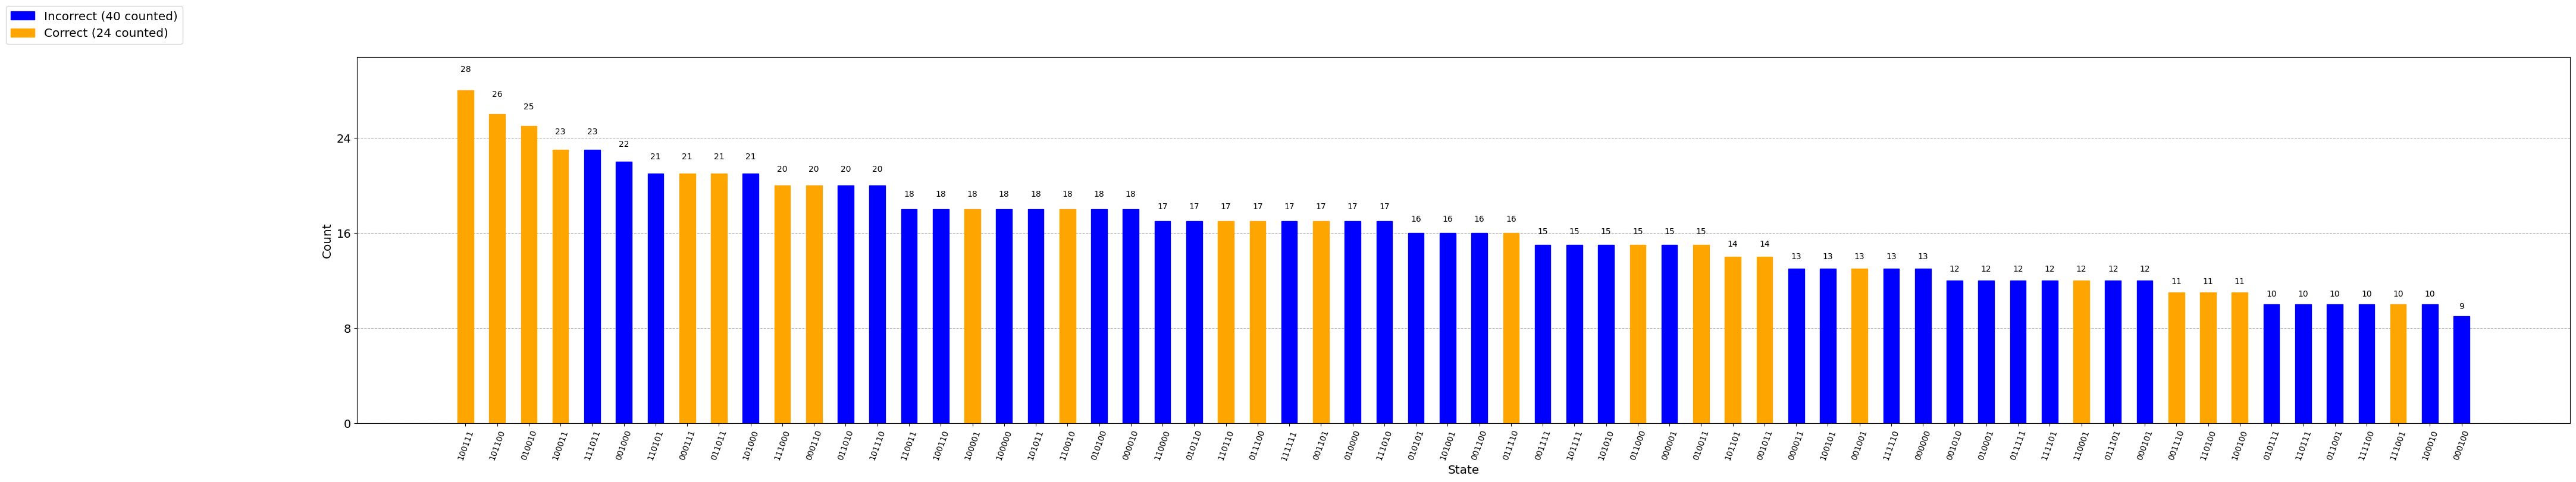

In [85]:
from qiskit.visualization import plot_histogram

plotMe = []
def plot_results(result, satisfies_disagree_list):

  # Plotting results
  counts = result.circuit_results[0]
  plot = plot_histogram(counts, figsize=(int(6*len(counts.keys())**(1/2)), 8), sort='value_desc')
  ax = plot.gca()
  ax.tick_params(axis='x', which='major', labelsize=10)
  ax.set_xlabel("State", fontsize = 'x-large')
  ax.set_ylabel("Count", fontsize = 'x-large')


  correct_count = 0
  states = ax.xaxis.get_ticklabels()
  for i in range(len(states)):
    if satisfies_disagree_list(states[i].get_text()):
      ax.containers[i][0].set(color = 'orange')
      correct_count += 1
    else:
      ax.containers[i][0].set(color = 'blue')

  leg = plot.legend(['Incorrect (' + str(len(states) - correct_count) + ' counted)',
                     'Correct (' + str(correct_count) + ' counted)'],
                    fontsize = 'x-large',
                    loc = 'upper left')
  leg.legendHandles[0].set_color('blue')
  leg.legendHandles[1].set_color('orange')

  display(plot)
plot_results(results, check_disagreement)


/var/folders/2_/qlpzqzms15122l6kvxdp657w0000gn/T/ipykernel_18705/3195024974.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('orange')


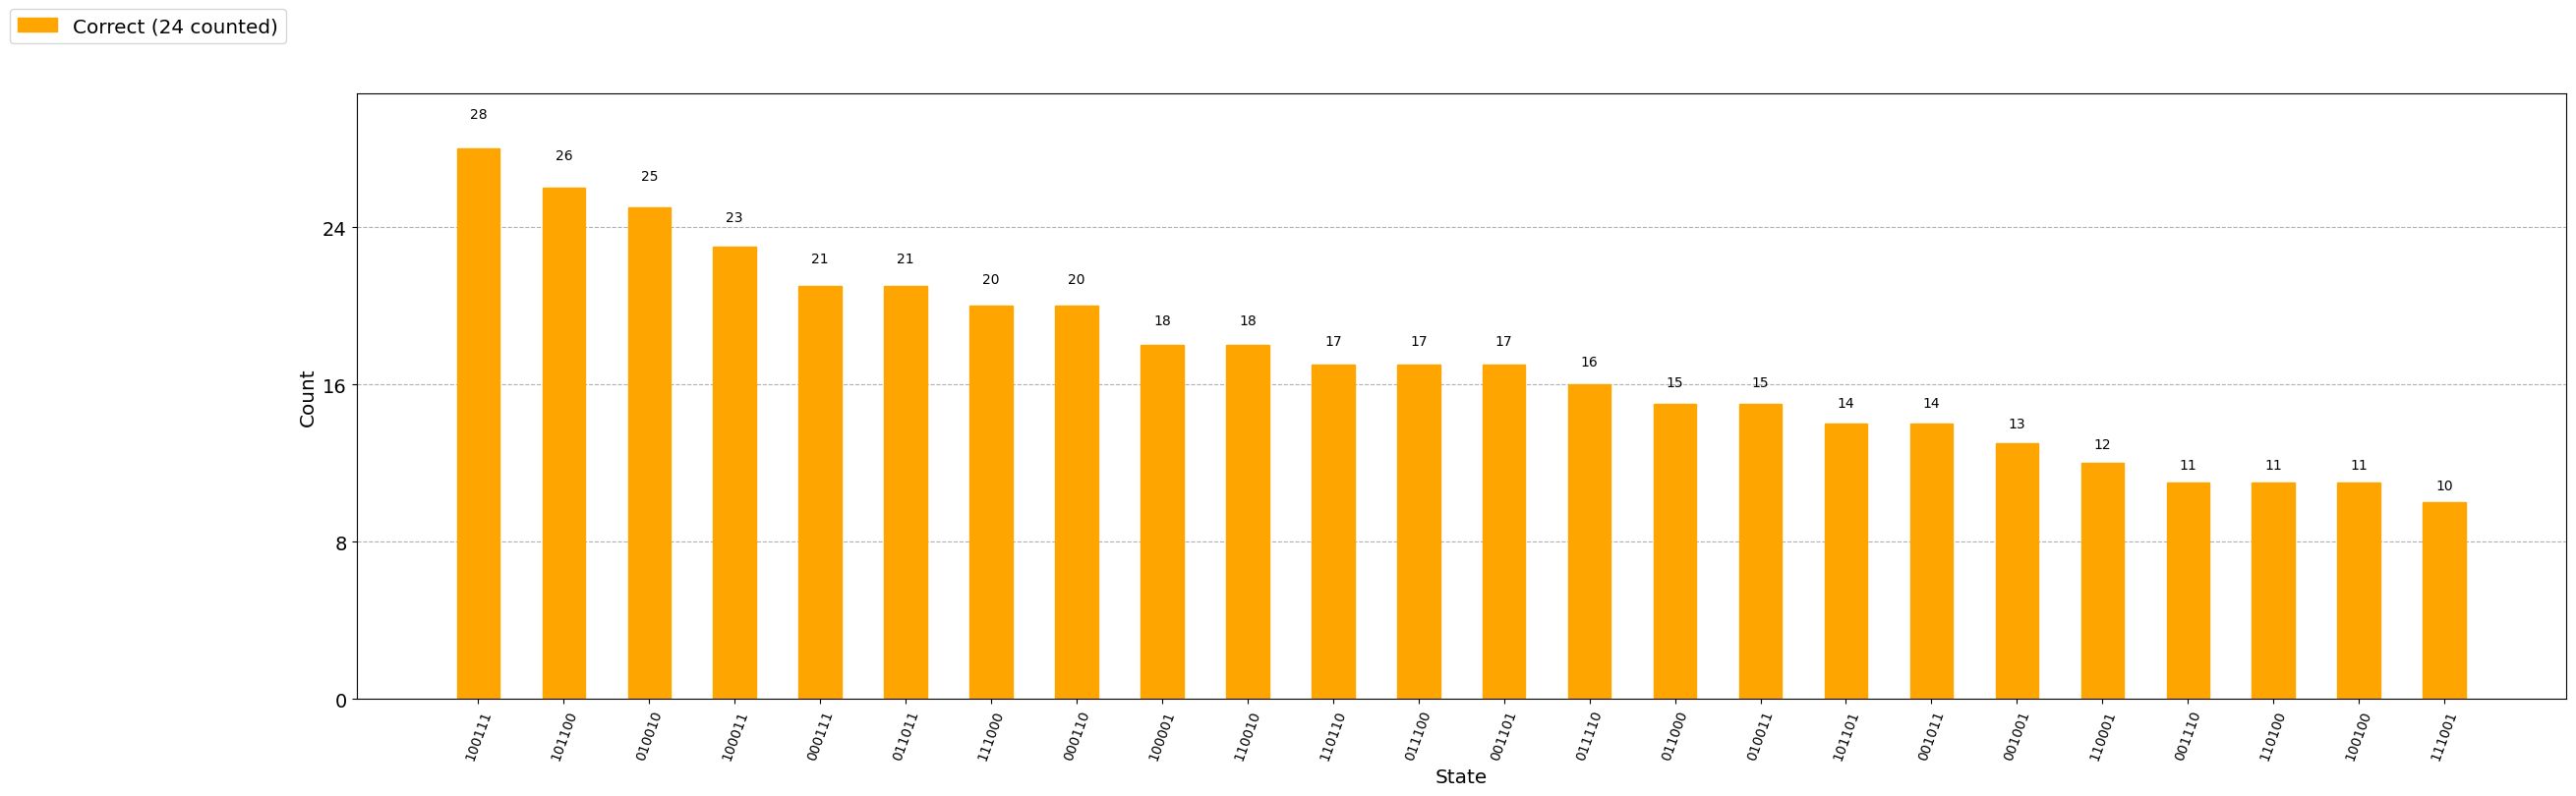

{   'assignment': '100111',
    'circuit_results': [   {   '000110': 20,
                               '000111': 21,
                               '001001': 13,
                               '001011': 14,
                               '001101': 17,
                               '001110': 11,
                               '010010': 25,
                               '010011': 15,
                               '011000': 15,
                               '011011': 21,
                               '011100': 17,
                               '011110': 16,
                               '100001': 18,
                               '100011': 23,
                               '100100': 11,
                               '100111': 28,
                               '101100': 26,
                               '101101': 14,
                               '110001': 12,
                               '110010': 18,
                               '110100': 11,
                           

In [86]:
def plot_and_filter_results(result, satisfies_disagree_list):
    # Assuming result.circuit_results[0] is a dictionary like {'state': count}
    counts = result.circuit_results[0]
    
    # Filter counts for "correct" states only
    correct_counts = {state: count for state, count in counts.items() if satisfies_disagree_list(state)}

    # Plotting the filtered results
    plot = plot_histogram(correct_counts, figsize=(int(6*len(correct_counts.keys())**(1/2)), 8), sort='value_desc')
    ax = plot.gca()
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xlabel("State", fontsize = 'x-large')
    ax.set_ylabel("Count", fontsize = 'x-large')

    # Set all bars to orange since they are all "correct" by the filter
    for container in ax.containers:
        container[0].set(color='orange')

    # Adjusting the legend to reflect only "correct" states
    leg = plot.legend(['Correct (' + str(len(correct_counts)) + ' counted)'],
                      fontsize = 'x-large', loc = 'upper left')
    leg.legendHandles[0].set_color('orange')

    display(plot)

    # Return the filtered results object for "correct" states
    filtered_result = result
    filtered_result.circuit_results[0] = correct_counts
    return filtered_result

# Call the modified function with your results and check_disagreement function
filtered_results = plot_and_filter_results(results, check_disagreement)
print(filtered_results)

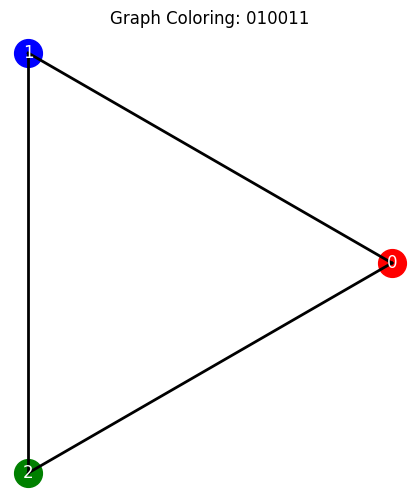

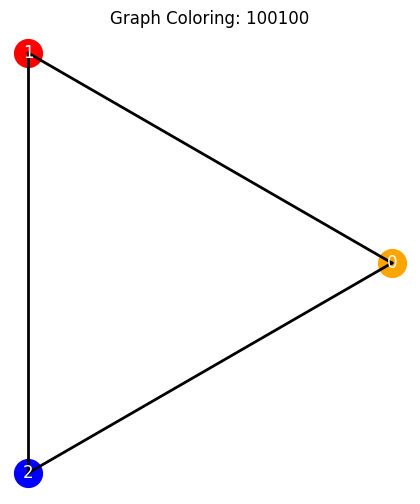

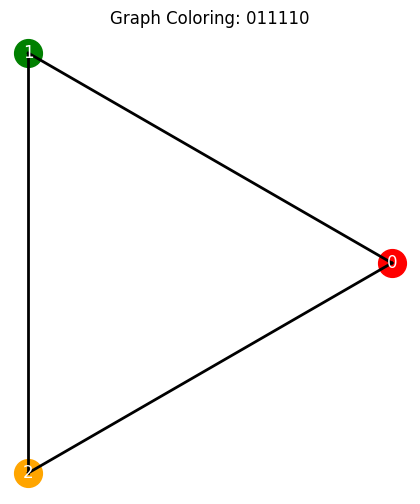

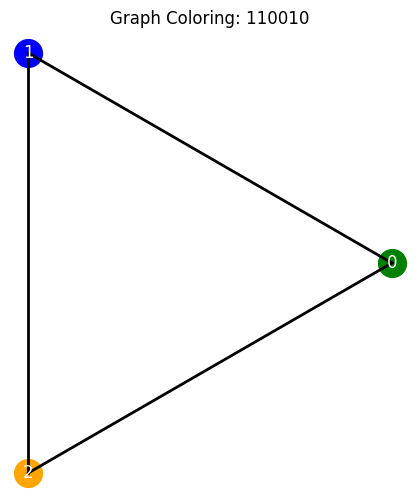

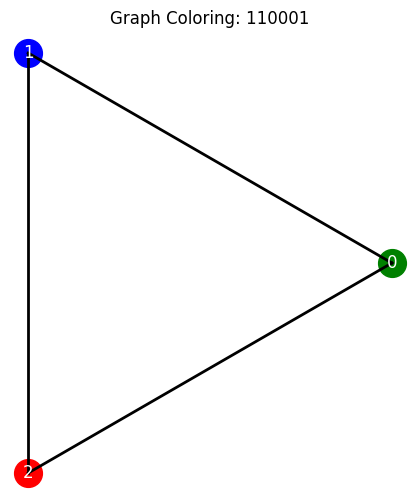

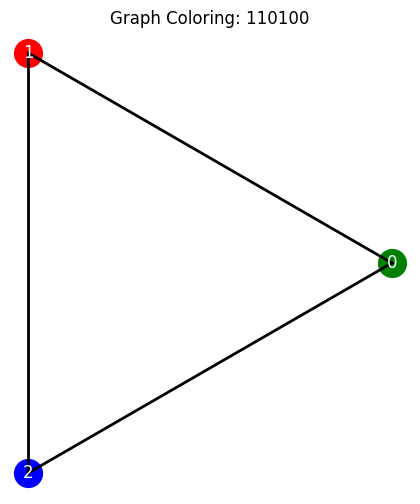

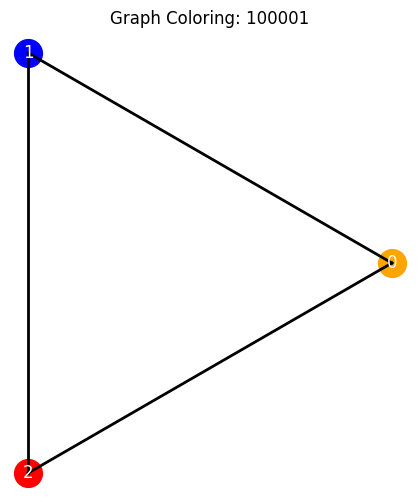

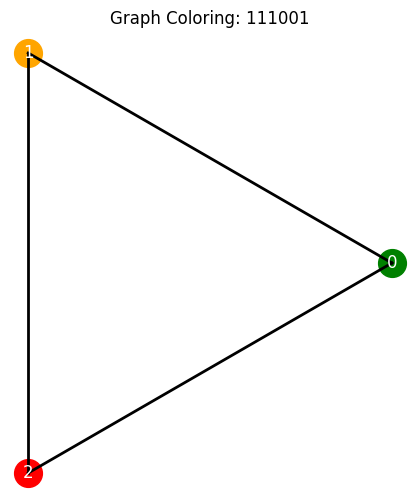

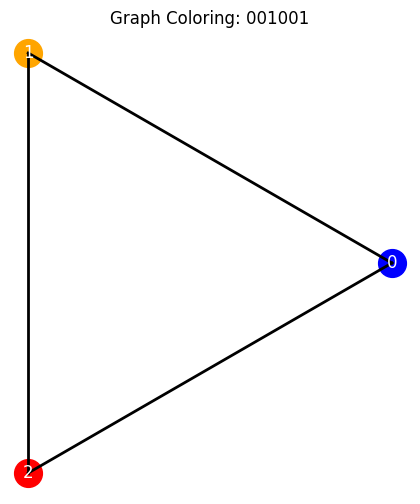

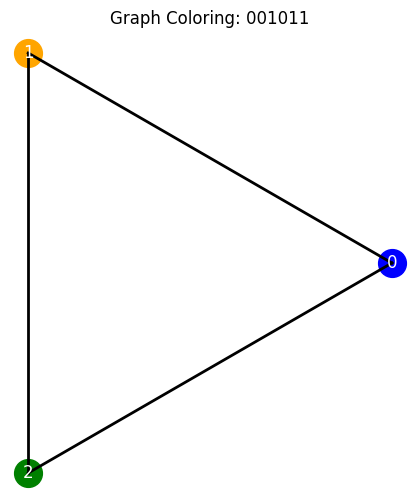

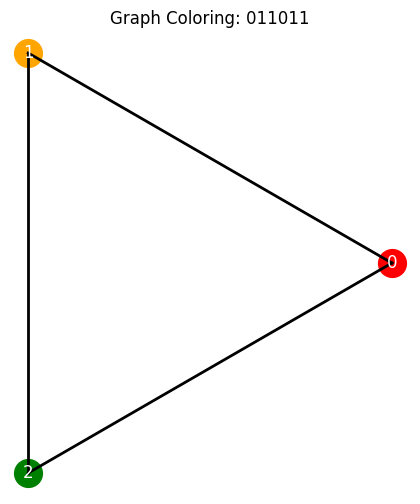

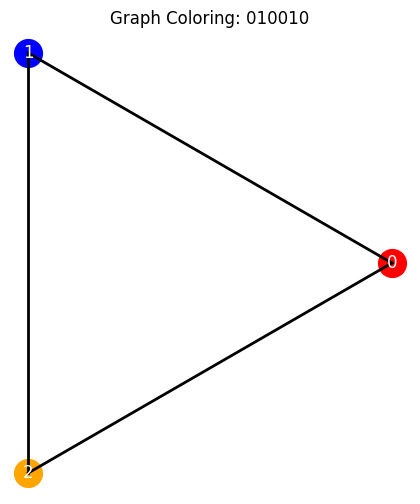

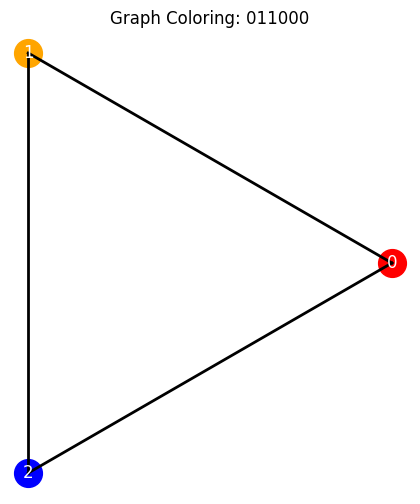

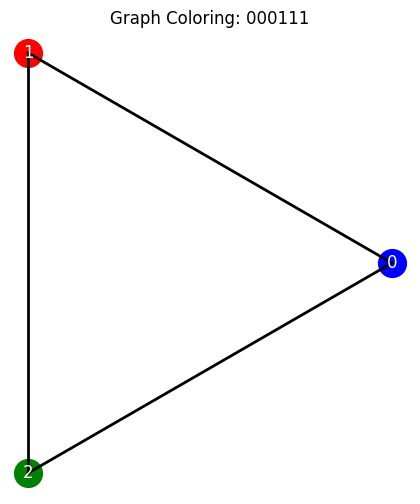

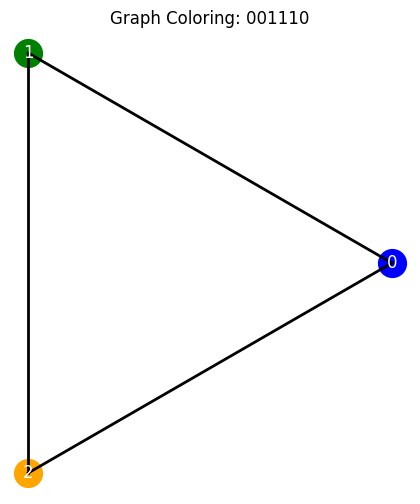

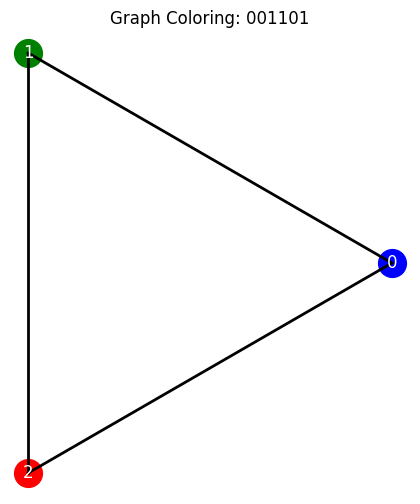

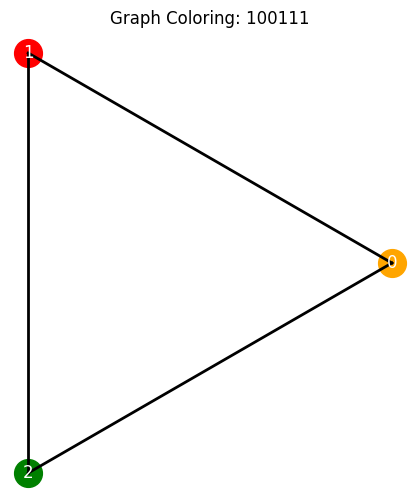

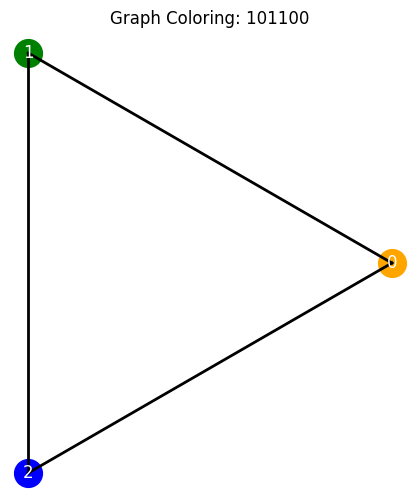

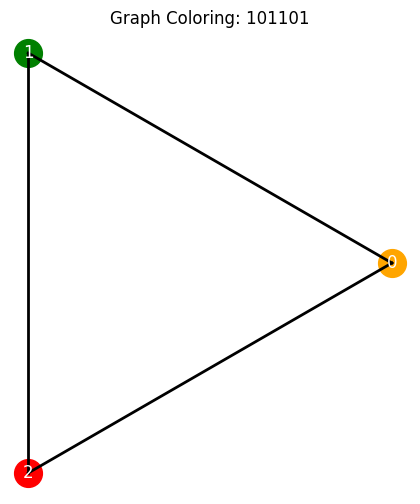

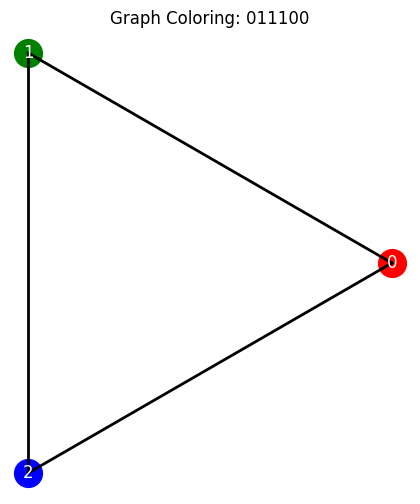

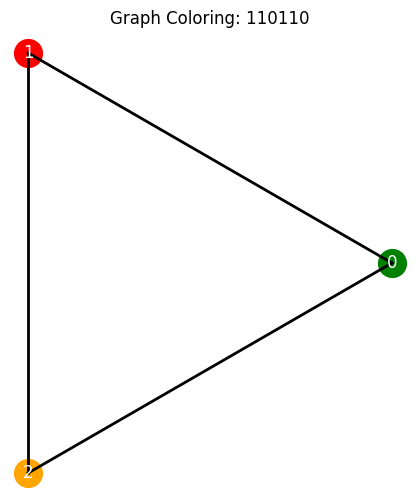

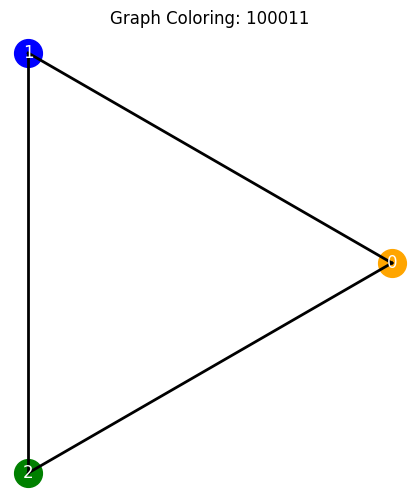

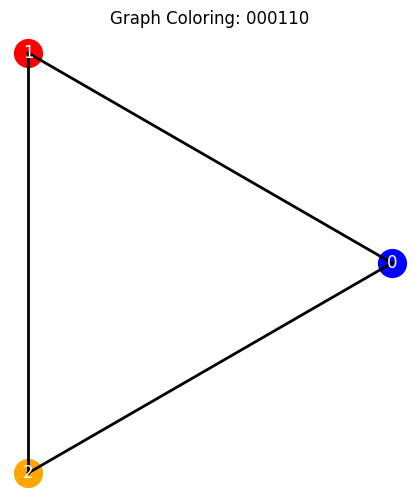

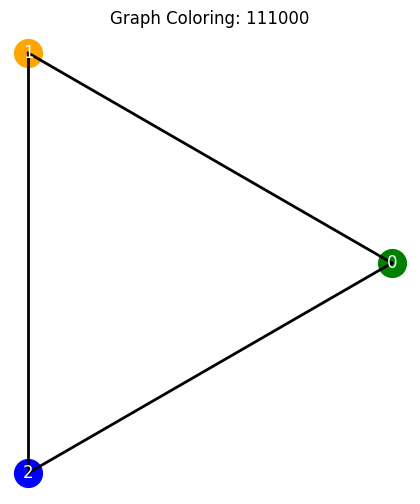

In [87]:
def plot_colored_graphs_for_all_results(circuit_results, adjacency_list):
    """
    Plots colored graphs for each binary string in the circuit results.
    The colors are represented as follows in binary:
    00: White, 01: Red, 10: Orange, 11: Black.
    """
    color_map = {'00': 'blue', '01': 'red', '10': 'orange', '11': 'green'}
    num_nodes = len(adjacency_list)
    
    # Calculate positions for the nodes so they are placed in a circle
    positions = {node: (np.cos(2 * np.pi * node / num_nodes), np.sin(2 * np.pi * node / num_nodes))
                 for node in adjacency_list}
    
    for result in circuit_results[0]:
        node_colors = [color_map[result[i:i+2]] for i in range(0, len(result), 2)]
        
        fig, ax = plt.subplots(figsize=(8, 6))
        for node, pos in positions.items():
            ax.plot(pos[0], pos[1], 'o', color=node_colors[node], markersize=20)
            
        for node, neighbors in adjacency_list.items():
            for neighbor in neighbors:
                if node < neighbor:  # To ensure each edge is drawn once
                    start_pos, end_pos = positions[node], positions[neighbor]
                    ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-', lw=2)
                    
            ax.text(positions[node][0], positions[node][1], str(node), color='white', fontsize=12, ha='center', va='center')
        
        ax.set_aspect('equal')
        plt.axis('off')
        plt.title(f'Graph Coloring: {result}')
        plt.show()

plot_colored_graphs_for_all_results(filtered_results.circuit_results, result.get( 'adjacency_list'))
